### Loading the libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [2]:
train_df = pd.read_csv("train-flattened_v2.csv")
print(train_df.shape)

(903653, 55)


In [3]:
train_df['trafficSource.adContent'].value_counts()

Google Merchandise Collection                  5122
Google Online Store                            1245
Display Ad created 3/11/14                      967
Full auto ad IMAGE ONLY                         822
Ad from 12/13/16                                610
Ad from 11/3/16                                 489
Display Ad created 3/11/15                      392
{KeyWord:Google Brand Items}                    251
{KeyWord:Google Merchandise}                    155
Ad from 11/7/16                                 123
Google Merchandise                               87
First Full Auto Template Test Ad                 87
20% discount                                     75
{KeyWord:Google Branded Gear}                    67
{KeyWord:Looking for Google Bags?}               65
Swag with Google Logos                           64
Display Ad created 11/17/14                      50
{KeyWord:Want Google Stickers?}                  42
JD_5a_v1                                         41
{KeyWord:Goo

### Sneak Peek at the data

In [4]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google


### Getting the categorical and numerical columns

In [5]:
cols = train_df.columns
num_cols = train_df._get_numeric_data().columns
factor_cols = list(set(cols) - set(num_cols))

### Getting the count of missing values in the categorical values and plotting the same

Text(0.5,1,'Missing Values in Categorical Features')

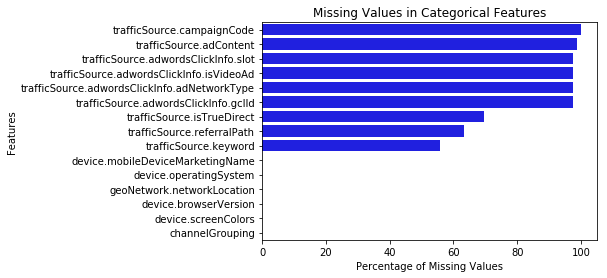

In [6]:
total_test = train_df[factor_cols].isnull().sum().sort_values(ascending=False)
percent = (train_df[factor_cols].isnull().sum()/train_df[factor_cols].isnull().count()).sort_values(ascending=False)*100
data_to_be_removed = pd.concat([total_test, percent], axis=1,join='outer', keys=['Missing Value Count', 'Percentage of Missing Values'])
data_to_be_removed.index.name ='Features'
#data_to_be_removed.head(20)
sns.barplot(y = data_to_be_removed.index[:15],x = data_to_be_removed['Percentage of Missing Values'][:15],color='blue').set_title("Missing Values in Categorical Features")

In [7]:
missing_cols = list(data_to_be_removed[data_to_be_removed['Percentage of Missing Values']>50.0].iloc[:,1].index)

### Getting the count of missing values in the continuous variables and plotting it

Text(0.5,1,'Missing Values in Continuous Features')

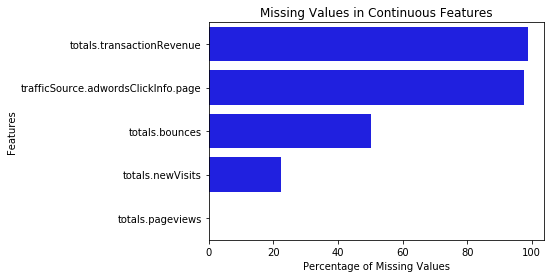

In [8]:
total_test1 = train_df[num_cols].isnull().sum().sort_values(ascending=False)
percent1 = (train_df[num_cols].isnull().sum()/train_df[num_cols].isnull().count()).sort_values(ascending=False)*100
data_to_be_removed1 = pd.concat([total_test1, percent1], axis=1,join='outer', keys=['Missing Value Count', 'Percentage of Missing Values'])
data_to_be_removed1.index.name ='Features'
#data_to_be_removed.head(20)
sns.barplot(y = data_to_be_removed1.index[:5],x = data_to_be_removed1['Percentage of Missing Values'][:5],color='blue').set_title("Missing Values in Continuous Features")

     Note : The feature 'totals.transactionRevenue' is the revenue generated in every session/log in of each user and if it's   missing, it means that no revenue was generated. So, rather than dropping the missing values, we should recode it to 0 in this case


### Removing Categorical features with just 1 level

In [9]:
single_level_cols = [cols for cols in train_df[factor_cols].columns if train_df[cols].nunique(dropna=False)==1 ]
train_df.drop(single_level_cols,axis=1,inplace=True)
print(train_df.shape)

(903653, 37)


### Before proceeding further with the exploratory analysis, we will generate our target variable of interest : Flag indicating if a customer is a revenue generating customer or not

In [10]:
group_cols = ['fullVisitorId']
counted = 'totals.transactionRevenue'
agg_name = 'totals.transactionRevenue_sum'
gp = train_df[group_cols+[counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted:agg_name})
#print(gp)
#train = train.merge(gp, on=group_cols, how='left')
gp['Revenue_Generating_Flag'] = np.where(gp['totals.transactionRevenue_sum']>0,1,0)
cols = ['fullVisitorId','Revenue_Generating_Flag']

train_df1 = pd.merge(train_df,gp[cols],on='fullVisitorId',how='inner')

### Data Wrangling / Cleaning

In [11]:
class Wrangler:
    
    def browser_wrangling(self,x):
        top_10_browsers = ['chrome','safari','firefox','internet explorer','edge','android webview','safari (in-app)','opera mini','opera','uc browser']
        #browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
        #mobile_browsers = ['android','samsung','mini','iphone','in-app','playstation','mozilla','chrome','blackberry','nokia','browser','amazon','lunascape','netscape','konqueror','puffin']
    
        if x in top_10_browsers:
            return x.lower()
    
        #elif x in mobile_browsers:
             # return 'mobile browser'
    
        elif '(not set)' in x:
            return x
    
        else:
            return 'others'

        
    def source_wrangling(self,x):
        if  ('google' in x):
            return 'google'
        elif  ('youtube' in x):
            return 'youtube'
        elif 'yahoo' in x:
            return 'yahoo'
        elif 'facebook' in x:
            return 'facebook'
        elif 'reddit' in x:
            return 'reddit'
        elif 'bing' in x:
            return 'bing'
        elif 'quora' in x:
            return 'quora'
        elif 'outlook' in x:
            return 'outlook'
        elif 'linkedin' in x:
            return 'linkedin'
        elif 'twitter' in x:
            return 'twitter'
        elif '(not set)' in x or 'nan' in x:
            return x
        else:
            return 'others'
        
    def device_os_wrangling(self,x):
        top_10_device_os = ['windows','macintosh','andorid','ios', 'linux','chrome os','windows phone']
        #browsers = ['chrome','safari','firefox','internet explorer','edge','opera','coc coc','maxthon','iron']
        #mobile_browsers = ['android','samsung','mini','iphone','in-app','playstation','mozilla','chrome','blackberry','nokia','browser','amazon','lunascape','netscape','konqueror','puffin']

        if x in top_10_device_os:
            return x.lower()

        #elif x in mobile_browsers:
         #   return 'mobile browser'

        elif '(not set)' in x:
            return x

        else:
            return 'others'
        
    def nw_domain_wrangling(self,x):
        tt = x['geoNetwork.networkDomain'].value_counts()
        tt = pd.DataFrame(tt)
        #tt['geoNetwork.networkDomain'] = tt.index
        tt['column_names'] = tt.index
        cols = ['values','geoNetwork.networkDomain']
        tt.columns  = cols
        #tt
        x = pd.merge(x,tt,on='geoNetwork.networkDomain',how='left')
        x['geoNetwork.networkDomain'] = np.where(x['values']<=20,'Others',x['geoNetwork.networkDomain'])
        del x['values']
        x['geoNetwork.networkDomain'].value_counts()
        return x
    
    def plots(self,x):
        bar1x=[]
        bar1y=[]
        for i in range(len(x)):
    
            bar1x.append(x.index[i])
            bar1y.append(x[i])

        plt.figure(figsize=(8, 10))
        g=sns.barplot(x=bar1y, y=bar1x)
        for i in range(len(bar1y)):
            g.text(x = bar1y[i] , y = i, s = bar1y[i], size = 10)


In [12]:
wrang = Wrangler()

Plot of top 10 device browsers before transformation
Plot of device browsers after transformation


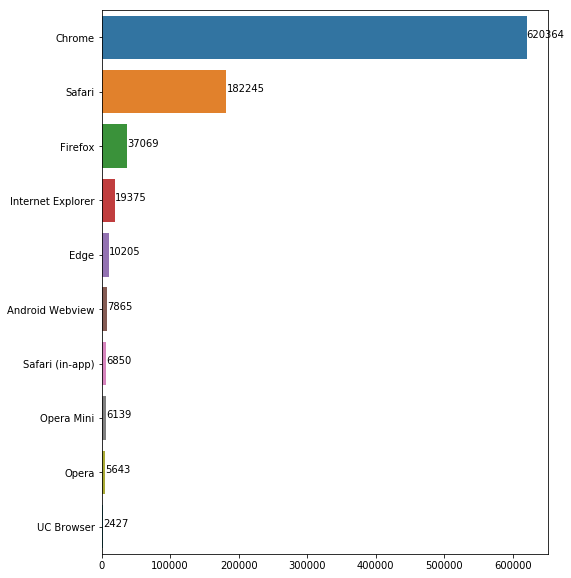

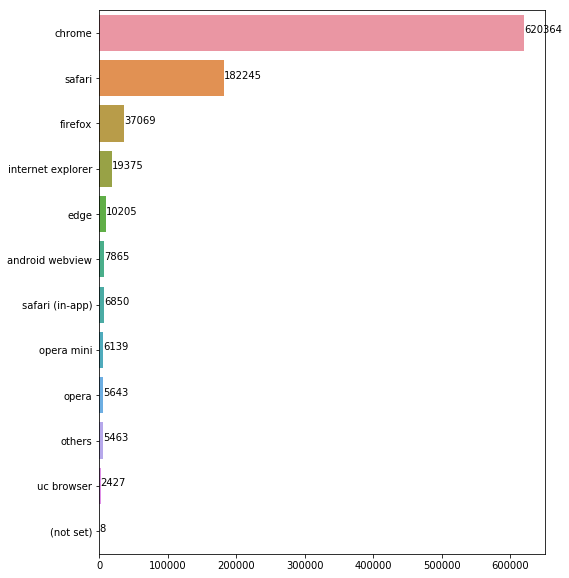

In [13]:
x=train_df1['device.browser'].value_counts()
print("Plot of top 10 device browsers before transformation")
wrang.plots(x[:10])
train_df1['device.browser'] = train_df1['device.browser'].map(lambda x:wrang.browser_wrangling(str(x).lower())).astype('str')
x=train_df1['device.browser'].value_counts()
print("Plot of device browsers after transformation")
wrang.plots(x)


Plot of top 10 Sources before transformation
Plot of Sources after transformation


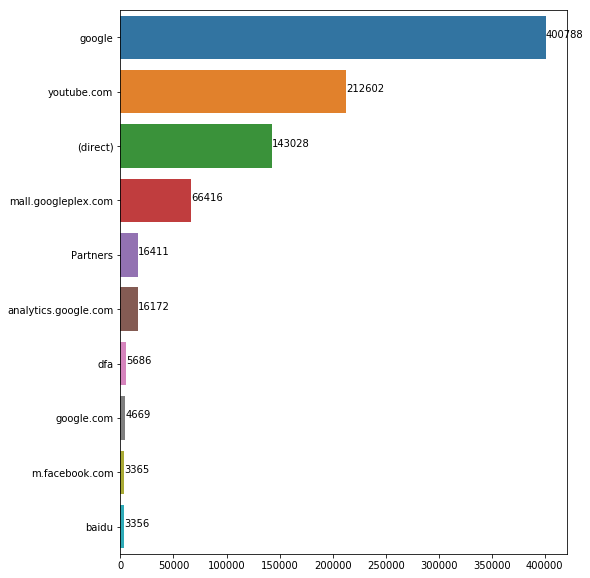

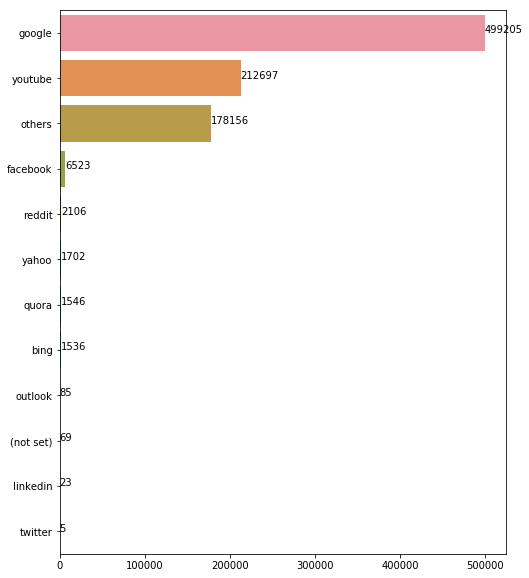

In [14]:
x=train_df1['trafficSource.source'].value_counts()
print("Plot of top 10 Sources before transformation")
wrang.plots(x[:10])
train_df1['trafficSource.source'] = train_df1['trafficSource.source'].map(lambda x:wrang.source_wrangling(str(x).lower())).astype('str')
x=train_df1['trafficSource.source'].value_counts()
print("Plot of Sources after transformation")
wrang.plots(x)


Plot of top 10 Operating Systems before transformation
Plot of Operating Systems after transformation


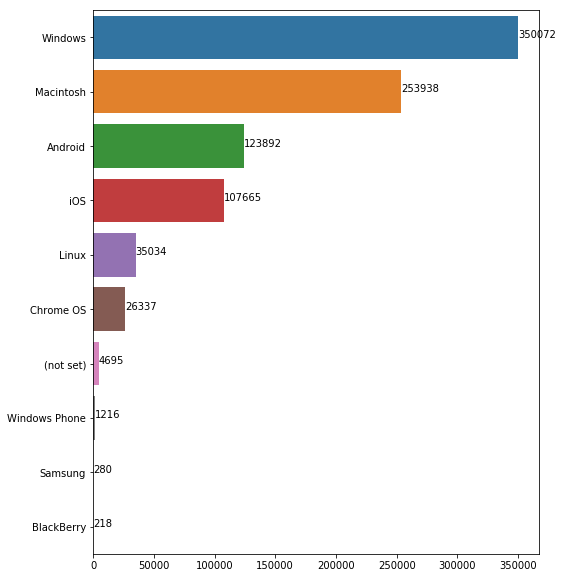

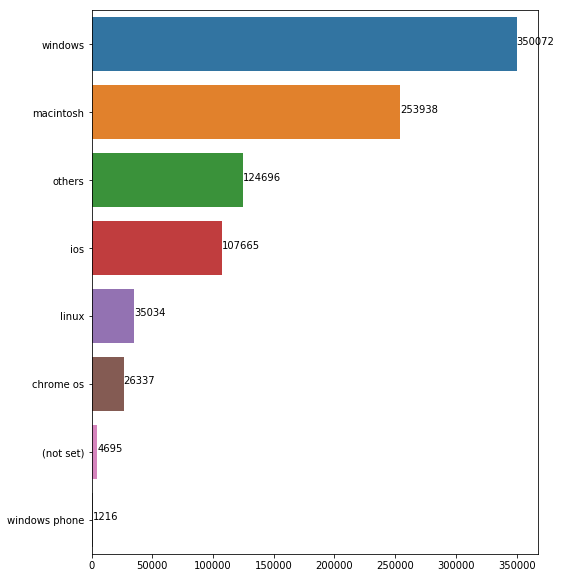

In [15]:
print("Plot of top 10 Operating Systems before transformation")
x=train_df1['device.operatingSystem'].value_counts()
wrang.plots(x[:10])
train_df1['device.operatingSystem'] = train_df1['device.operatingSystem'].map(lambda x:wrang.device_os_wrangling(str(x).lower())).astype('str')
x=train_df1['device.operatingSystem'].value_counts()
print("Plot of Operating Systems after transformation")
wrang.plots(x)

Plot of top 10 Network Domains before transformation
Plot of Network Domains after transformation


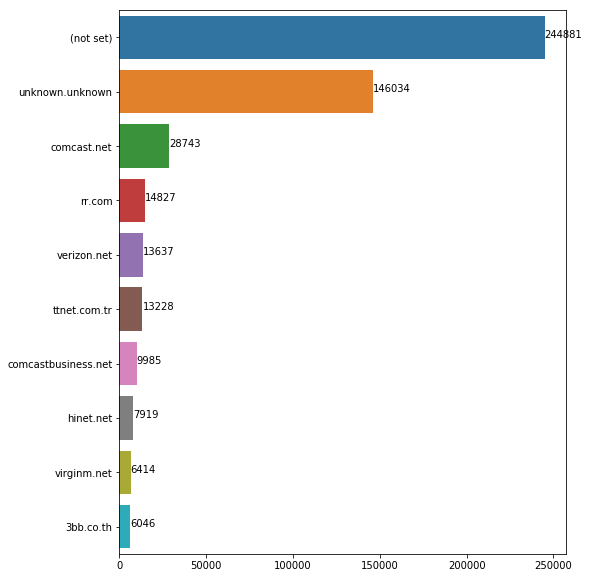

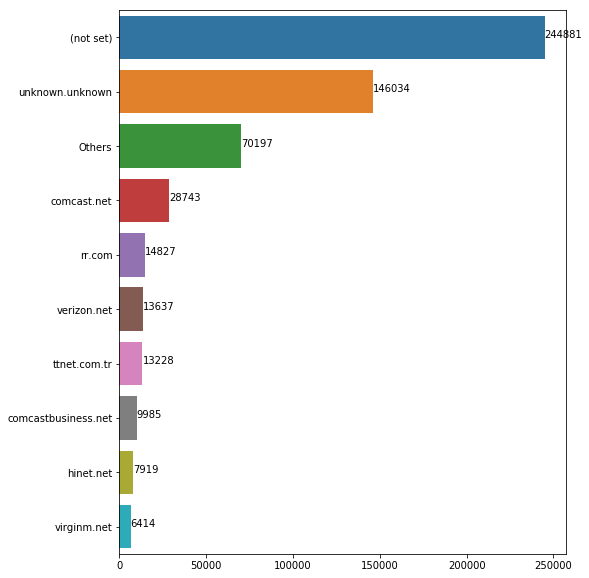

In [16]:
x=train_df1['geoNetwork.networkDomain'].value_counts()
print("Plot of top 10 Network Domains before transformation")
wrang.plots(x[:10])
train_df1 = wrang.nw_domain_wrangling(train_df1)
x=train_df1['geoNetwork.networkDomain'].value_counts()
print("Plot of Network Domains after transformation")
wrang.plots(x[:10])



### Creating New Features

In [17]:
train_df1['date_of_visit'] = pd.to_datetime(train_df1['visitStartTime'], unit='s')
train_df1['day_of_the_week'] = train_df1['date_of_visit'].dt.dayofweek
train_df1['hour_of_the_day'] = train_df1['date_of_visit'].dt.hour
train_df1['day_of_the_month'] = train_df1['date_of_visit'].dt.day

In [18]:
train_df1['source.country'] = train_df1['trafficSource.source'] + '_' + train_df1['geoNetwork.country']
train_df1['campaign.medium'] = train_df1['trafficSource.campaign'] + '_' + train_df1['trafficSource.medium']
train_df1['browser.category'] = train_df1['device.browser'] + '_' + train_df1['device.deviceCategory']
train_df1['browser.os'] = train_df1['device.browser'] + '_' + train_df1['device.operatingSystem']

In [19]:
train_df1['device_deviceCategory_channelGrouping'] = train_df1['device.deviceCategory'] + "_" + train_df1['channelGrouping']
train_df1['channelGrouping_browser'] = train_df1['device.browser'] + "_" + train_df1['channelGrouping']
train_df1['channelGrouping_OS'] = train_df1['device.operatingSystem'] + "_" + train_df1['channelGrouping']
train_df1['content.source'] = train_df1['trafficSource.adContent'] + "_" + train_df1['source.country']
train_df1['medium.source'] = train_df1['trafficSource.medium'] + "_" + train_df1['source.country']

### Removing unwanted columns/features

In [20]:
excluded_features = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 
    'visitId', 'visitStartTime', 'vis_date', 'nb_sessions', 'max_visits'
]

excluded_features = excluded_features + missing_cols

categorical_features = [
    _f for _f in train_df1.columns
    if (_f not in excluded_features) & (train_df1[_f].dtype == 'object')
]

### Factorizing the categorical features

In [21]:
for f in categorical_features:
    train_df1[f], indexer = pd.factorize(train_df1[f])

In [22]:
req_features = [_f for _f in train_df1.columns if _f not in excluded_features]

In [23]:
train_df2 = train_df1[req_features + ['fullVisitorId']].groupby('fullVisitorId').mean()

In [24]:
train_df2['Revenue_Generating_Flag'].value_counts()

0    713689
1     10114
Name: Revenue_Generating_Flag, dtype: int64

Note : We can see that only 1.4% of the customers are Revenue Generating Customers

In [25]:
y = train_df2['Revenue_Generating_Flag']
X = train_df2.loc[:, train_df2.columns != 'Revenue_Generating_Flag']

In [26]:
del train_df2['Revenue_Generating_Flag']
train_df2 = train_df2.reset_index()

In [85]:
train, test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.3,random_state=20)

In [28]:
print(y_test.value_counts())
y_train.value_counts()

0    214107
1      3034
Name: Revenue_Generating_Flag, dtype: int64


0    499582
1      7080
Name: Revenue_Generating_Flag, dtype: int64

In [29]:
3034/(3034+214107)

0.013972487922594075

In [30]:
7080/(7080+499582)

0.013973812916697918

### Performing SMOTE

In [86]:
train.fillna(train.median(),inplace=True)
sm = SMOTE(random_state=12, ratio = 0.2)
x_train_res, y_train_res = sm.fit_sample(train, y_train)
x_train_res = pd.DataFrame(x_train_res)
x_train_res.columns = train.columns
y_train_res = pd.DataFrame(y_train_res)
#y_train_res.columns = y_train.columns

In [44]:
print(train.shape)
print(y_train.shape)
print(x_train_res.shape)
print(y_train_res.shape)

(506662, 34)
(506662,)
(599498, 34)
(599498, 1)


In [45]:
print(y_train_res[0].value_counts())

0    499582
1     99916
Name: 0, dtype: int64


In [46]:
99916/(99916+499582)

0.16666611064590708

In [47]:
skf = StratifiedKFold(n_splits=5)

In [48]:
for a,b in skf.split(x_train_res,y_train_res):
    print(y_train_res[0].iloc[a].value_counts())
    print(y_train_res[0].iloc[b].value_counts())

0    399665
1     79932
Name: 0, dtype: int64
0    99917
1    19984
Name: 0, dtype: int64
0    399665
1     79933
Name: 0, dtype: int64
0    99917
1    19983
Name: 0, dtype: int64
0    399666
1     79933
Name: 0, dtype: int64
0    99916
1    19983
Name: 0, dtype: int64
0    399666
1     79933
Name: 0, dtype: int64
0    99916
1    19983
Name: 0, dtype: int64
0    399666
1     79933
Name: 0, dtype: int64
0    99916
1    19983
Name: 0, dtype: int64


In [49]:
79932/(79932+399665)

0.1666649290967208

In [50]:
19984/(19984+99917)

0.16667083677367162

### Tuning Logistic Regression Hyperparameter

In [ ]:
lambda_vals = [0.001,0.01,0.1,1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]
#lambda_vals = [1000,10000,100000,1000000,10000000,100000000,1000000000,10000000000]
lambda_vals1 = np.reciprocal(lambda_vals)
acc_table = pd.DataFrame(columns = ['lambda_vals','CV_AUC'])
acc_table['lambda_vals'] = lambda_vals

j=0
for i in lambda_vals1:
    avg = 0
    for a,b in skf.split(x_train_res,y_train_res):
        trn_x, trn_y = x_train_res.iloc[a], y_train_res[0].iloc[a]
        val_x, val_y = x_train_res.iloc[b], y_train_res[0].iloc[b]
        lr = LogisticRegression(penalty = 'l2', C = i,random_state=20)
        lr.fit(trn_x,trn_y)
        test_pred = lr.predict_proba(val_x)[:,1]
        avg+=roc_auc_score(val_y, test_pred)

    avg1 = avg/5.0
    acc_table.iloc[j,1] = avg1
    j = j+1

In [ ]:
acc_table

### Building Logistic Regression Model on the obtained Hyperparameter

#### Keeping aside 20% of the train data as validation which can be used for ensemble and stacking later

In [51]:
#x_train_res = train
#y_train_res = y_train

x1_train, x1_test, y1_train, y1_test = train_test_split(x_train_res,y_train_res,
                                                stratify=y_train_res, 
                                                test_size=0.2,random_state=20)

In [52]:
val_table = pd.DataFrame(columns = ['Actuals','glm','rf','gbm'])
val_table['Actuals'] = y1_test[0]
test_table = pd.DataFrame(columns = ['Actuals','glm','rf','gbm'])
test_table['Actuals'] = y_test

In [53]:
#train_features = [_f for _f in x_train_res.columns if _f not in excluded_features]
x1_train.fillna(x1_train.median(),inplace=True)
x1_test.fillna(x1_test.median(),inplace=True)
test.fillna(test.median(),inplace=True)

lr = LogisticRegression(penalty = 'l2', C = 0.01,random_state=20)
lr.fit(x1_train,y1_train)

val_table['glm'] = lr.predict_proba(x1_test)[:,1]
test_table['glm'] = lr.predict_proba(test)[:,1]

In [54]:
val_table['glm'].describe()

count    1.199000e+05
mean     1.672000e-01
std      3.026137e-01
min      2.105859e-08
25%      9.066853e-04
50%      1.108280e-02
75%      1.232601e-01
max      1.000000e+00
Name: glm, dtype: float64

In [55]:
print(roc_auc_score(val_table['Actuals'], val_table['glm']))
avg1 = np.where(val_table['glm']<0.6,0,1)
#print(avg)
df_confusion = pd.crosstab(val_table['Actuals'], avg1)
df_confusion

0.979333796858729


col_0,0,1
Actuals,,
0,97676,2241
1,5608,14375


In [56]:
from sklearn.metrics import f1_score
f1_score(val_table['Actuals'], avg1)

0.7855405885406705

In [70]:
print(roc_auc_score(test_table['Actuals'], test_table['glm']))
avg1 = np.where(test_table['glm']<0.5,0,1)
#print(avg)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.9756972675571788


col_0,0,1
Actuals,,
0,207931,6176
1,688,2346


In [71]:
from sklearn.metrics import f1_score
f1_score(test_table['Actuals'], avg1)

0.4060228452751817

In [73]:
2346/(2346+688)

0.7732366512854317

### Tuning Random Forest Parameters

In [ ]:
param_grid = { 
    'n_estimators': [300,400,500],
    'max_depth' : [6,7,8]
}
rfc = RandomForestClassifier(random_state=20)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
CV_rfc.fit(x_train_res, y_train_res)

In [ ]:
print(CV_rfc.best_params_)

In [61]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x_train_res,y_train_res,
                                                stratify=y_train_res, 
                                                test_size=0.2,random_state=20)

In [63]:
#x1_train.fillna(x1_train.median(),inplace=True)
#x1_test.fillna(x1_test.median(),inplace=True)
#test.fillna(test.median(),inplace=True)

clf_rf = RandomForestClassifier(n_estimators=500,max_depth=8,random_state=20)
clf_rf.fit(x1_train, y1_train)

val_table['rf'] = clf_rf.predict_proba(x1_test)[:,1]
test_table['rf'] = clf_rf.predict_proba(test)[:,1]

In [67]:
print(roc_auc_score(test_table['Actuals'], test_table['rf']))
avg1 = np.where(test_table['rf']<0.5,0,1)
#print(avg)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.9854971701859689


col_0,0,1
Actuals,,
0,209216,4891
1,602,2432


In [68]:
from sklearn.metrics import f1_score
f1_score(test_table['Actuals'],avg1)

0.46963406391812307

In [69]:
2432/(2432+602)

0.8015820698747528

###  Gradient Boosting

In [110]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x_train_res,y_train_res,
                                                stratify=y_train_res, 
                                                test_size=0.2,random_state=20)

In [111]:
x1_train.fillna(x1_train.median(),inplace=True)
x1_test.fillna(x1_test.median(),inplace=True)
test.fillna(test.median(),inplace=True)

#cf_gb = GradientBoostingClassifier(learning_rate=0.03,max_depth=8,n_estimators=500,random_state=20)
cf_gb = GradientBoostingClassifier(random_state=20)
cf_gb.fit(x1_train, y1_train)

val_gbm = cf_gb.predict_proba(x1_test)[:,1]
test_gbm = cf_gb.predict_proba(test)[:,1]

In [118]:
print(roc_auc_score(test_table['Actuals'], test_gbm))
avg1 = np.where(test_gbm<0.3,0,1)
#print(avg)
df_confusion = pd.crosstab(test_table['Actuals'], avg1)
df_confusion

0.9860230948541648


col_0,0,1
Actuals,,
0,208383,5724
1,460,2574


In [120]:
2574/(2574+460)

0.8483849703361899

In [ ]:
from sklearn.metrics import f1_score
f1_score(test_table['Actuals'],avg1)

#####################################################################################

In [ ]:
#acc_table_val = pd.DataFrame(columns = ['Test Values','Fold1_glm','Fold2_glm','Fold3_glm','Fold4_glm','Fold5_glm'])
#acc_table_val['Test Values'] = y_test

acc_table_test = pd.DataFrame(columns = ['Test Values','Fold1_glm','Fold2_glm','Fold3_glm','Fold4_glm','Fold5_glm','Fold1_rf','Fold2_rf','Fold3_rf','Fold4_rf','Fold5_rf','Fold1_xgb','Fold2_xgb','Fold3_xgb','Fold4_xgb','Fold5_xgb'])
acc_table_test['Test Values'] = y_test
cut_off_table = pd.DataFrame(columns=['Folds','Cut_off'])
cut_off_table['Folds'] = ['Folds1','Folds2','Folds3','Folds4','Folds5']

train_features = [_f for _f in x_train_res.columns if _f not in excluded_features]
importances = pd.DataFrame()
oof_reg_preds = np.zeros(x_train_res.shape[0])

alg=LogisticRegression(penalty = 'l2', C = 0.01,random_state=20)
#kf=KFold(x_train_res.shape[0],n_folds=5,random_state=20)
#listfold=list(kf)
#skf = cross_validation.StratifiedKFold(y_train_res[0], n_folds=5)
test_preds = np.zeros(test.shape[0])
test.fillna(test.median(),inplace=True)

sub_reg_preds = np.zeros(test.shape[0])
i =1
for a,b in skf.split(x_train_res,y_train_res):
    trn_x, trn_y = x_train_res[train_features].iloc[a], y_train_res[0].iloc[a]
    val_x, val_y = x_train_res[train_features].iloc[b], y_train_res[0].iloc[b]
    #print(trn_x.head())
    trn_x.fillna(trn_x.median(),inplace=True)
    val_x.fillna(val_x.median(),inplace=True)
    lr = LogisticRegression(random_state = 0)
    lr.fit(trn_x,trn_y)
    oof_reg_preds = lr.predict_proba(val_x)[:,1]
    print("Validation AUC-ROC value for Fold {} is {}".format(i,roc_auc_score(val_y, oof_reg_preds)))
    
    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(val_y,oof_reg_preds)
    cut_off_table.iloc[i-1,1] = thresholds[np.argmax(tpr - fpr)]
    
    _preds = lr.predict_proba(test[train_features])[:,1]
    acc_table_test.iloc[:,i] = _preds
    i+=1
    #sub_reg_preds += _preds# / len(folds)
    #sub_reg_preds = np.add(sub_reg_preds,_preds)
    
        
avg = (acc_table_test['Fold1_glm'] + acc_table_test['Fold2_glm'] +acc_table_test['Fold3_glm'] + acc_table_test['Fold4_glm'] + acc_table_test['Fold5_glm'])/5.0   
print("Test AUC-ROC value is {}".format(roc_auc_score(acc_table_test['Test Values'], avg)))

In [ ]:
cut_off_table

In [ ]:
avg.describe()

In [ ]:
avg1 = avg
cut_off_table['Cut_off'].max(axis=0)
avg1 = np.where(avg1<0.195079,0,1)
#print(avg)
df_confusion = pd.crosstab(acc_table_test['Test Values'], avg1)
df_confusion

In [ ]:
from sklearn.metrics import f1_score
f1_score(acc_table_test['Test Values'], avg1)

In [ ]:
from sklearn.model_selection import train_test_split
train, test, y_train, y_test = train_test_split(X, y,
                                                stratify=y, 
                                                test_size=0.3,random_state=20)

from imblearn.over_sampling import SMOTE
train.fillna(train.median(),inplace=True)
sm = SMOTE(random_state=12, ratio = 0.2)
x_train_res, y_train_res = sm.fit_sample(train, y_train)
x_train_res = pd.DataFrame(x_train_res)
x_train_res.columns = train.columns
y_train_res = pd.DataFrame(y_train_res)
#y_train_res.columns = y_train.columns

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_features = [_f for _f in x_train_res.columns if _f not in excluded_features]
importances = pd.DataFrame()
oof_reg_preds = np.zeros(x_train_res.shape[0])
sub_reg_preds = np.zeros(test.shape[0])

#acc_table = pd.DataFrame(columns = ['Test Values','Fold1','Fold2','Fold3','Fold4','Fold5'])
#acc_table['Test Values'] = y_test

cut_off_table = pd.DataFrame(columns=['Folds','Cut_off'])
cut_off_table['Folds'] = ['Folds1','Folds2','Folds3','Folds4','Folds5']

test.fillna(test.median(),inplace=True)

i =6
for a,b in skf:
    trn_x, trn_y = x_train_res[train_features].iloc[a], y_train_res[0].iloc[a]
    val_x, val_y = x_train_res[train_features].iloc[b], y_train_res[0].iloc[b]
    
    #trn_x.fillna(trn_x.median(),inplace=True)
    #val_x.fillna(val_x.median(),inplace=True)
    
    clf_rf = RandomForestClassifier(n_estimators=200,random_state=10)
    clf_rf.fit(trn_x, trn_y)
    
    oof_reg_preds = clf_rf.predict_proba(val_x)[:,1]
    print("Validation AUC-ROC value for Fold {} is {}".format(i-5,roc_auc_score(val_y, oof_reg_preds)))
    
    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(val_y,oof_reg_preds)
    cut_off_table.iloc[i-6,1] = thresholds[np.argmax(tpr - fpr)]
    
    _preds = clf_rf.predict_proba(test[train_features])[:,1]
    acc_table_test.iloc[:,i] = _preds
    i+=1
    #_preds[_preds < 0] = 0
    #sub_reg_preds = np.add(sub_reg_preds,_preds)

avg = (acc_table_test['Fold1_rf'] + acc_table_test['Fold2_rf'] +acc_table_test['Fold3_rf'] + acc_table_test['Fold4_rf'] + acc_table_test['Fold5_rf'])/5.0   
print("Test AUC-ROC value is {}".format(roc_auc_score(acc_table_test['Test Values'], avg)))

In [ ]:
cut_off_table

In [ ]:
avg1 = avg
cut_off_table['Cut_off'].max(axis=0)
avg1 = np.where(avg1<0.585,0,1)
#print(avg)
df_confusion = pd.crosstab(acc_table_test['Test Values'], avg1)
df_confusion

In [ ]:
from sklearn.metrics import f1_score
f1_score(acc_table_test['Test Values'], avg1)

In [ ]:
import xgboost as xgb
from sklearn.cross_validation import KFold

train_features = [_f for _f in x_train_res.columns if _f not in excluded_features]
importances = pd.DataFrame()
oof_reg_preds = np.zeros(x_train_res.shape[0])
sub_reg_preds = np.zeros(test.shape[0])

acc_table = pd.DataFrame(columns = ['Test Values','Fold1','Fold2','Fold3','Fold4','Fold5'])
acc_table['Test Values'] = y_test

cut_off_table = pd.DataFrame(columns=['Folds','Cut_off'])
cut_off_table['Folds'] = ['Folds1','Folds2','Folds3','Folds4','Folds5']

i =11
for a,b in skf:
    trn_x, trn_y = x_train_res[train_features].iloc[a], y_train_res[0].iloc[a]
    val_x, val_y = x_train_res[train_features].iloc[b], y_train_res[0].iloc[b]
    #print(trn_x.head())
    #trn_x.fillna(trn_x.median(),inplace=True)
    #val_x.fillna(val_x.median(),inplace=True)
    clf = xgb.XGBClassifier(
            num_leaves=31,
            learning_rate=0.03,
            n_estimators=500,
            subsample=.9,
            colsample_bytree=.9,
            random_state=1
        )
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x,val_y)],
        early_stopping_rounds=20,
        verbose=100,
        eval_metric='auc'
        #objective='multi:softprob'
        )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = clf.feature_importances_

    imp_df['fold'] = i
    importances = pd.concat([importances, imp_df], axis=0)
    
    best_iteration = clf.get_booster().best_ntree_limit

    oof_reg_preds = clf.predict_proba(val_x,best_iteration)[:,1]
    #oof_reg_preds = lr.predict_proba(val_x)[:,1]
    #print(oof_reg_preds)
    print("Validation AUC-ROC value for Fold {} is {}".format(i-10,roc_auc_score(val_y, oof_reg_preds)))
    
    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(val_y,oof_reg_preds)
    cut_off_table.iloc[i-11,1] = thresholds[np.argmax(tpr - fpr)]
    
    best_iteration = clf.get_booster().best_ntree_limit
    #print(best_iteration)
    #oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = clf.predict_proba(test[train_features],best_iteration)[:,1]
    acc_table_test.iloc[:,i] = _preds
    i+=1
    #_preds[_preds < 0] = 0
    #sub_reg_preds = np.add(sub_reg_preds,_preds)
avg = (acc_table_test['Fold1_xgb'] + acc_table_test['Fold2_xgb'] +acc_table_test['Fold3_xgb'] + acc_table_test['Fold4_xgb'] + acc_table_test['Fold5_xgb'])/5.0   
print("Test AUC-ROC value is {}".format(roc_auc_score(acc_table_test['Test Values'], avg)))
#print("Test AUC-ROC value is {}".format(roc_auc_score(y_test, sub_reg_preds)))

In [ ]:
cut_off_table

In [ ]:
avg1 = avg
cut_off_table['Cut_off'].max(axis=0)
avg1 = np.where(avg1<0.458805,0,1)
df_confusion = pd.crosstab(acc_table_test['Test Values'], avg1)
from sklearn.metrics import f1_score
print(f1_score(acc_table_test['Test Values'], avg1))
#df_confusion = pd.crosstab(acc_table_test['Test Values'], avg1)
df_confusion

In [ ]:
#acc_table_test.iloc[:,1:16]
ensemble_value = acc_table_test.iloc[:,1:15].mean(axis=1)
print("Ensembled Test AUC-ROC value is {}".format(roc_auc_score(acc_table_test['Test Values'], ensemble_value)))

In [ ]:
avg1_v1 = np.where(ensemble_value<0.458805,0,1)
df_confusion = pd.crosstab(acc_table_test['Test Values'], avg1_v1)
from sklearn.metrics import f1_score
print(f1_score(acc_table_test['Test Values'], avg1_v1))
#df_confusion = pd.crosstab(acc_table_test['Test Values'], avg1)
df_confusion